<a href="https://colab.research.google.com/github/TOOBANOOR123/DataScience_BootCamp/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the dataset

In [ ]:
import numpy as np

from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


## Define our Evaluation Benchmark

In [ ]:
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

## Run the benchmark

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.085s	69545	0.598	0.645	0.621	0.469	0.617	0.145
random   	0.064s	69735	0.681	0.723	0.701	0.574	0.698	0.194
PCA-based	0.020s	69513	0.600	0.647	0.622	0.468	0.618	0.172
__________________________________________________________________________________


## Visualize the results

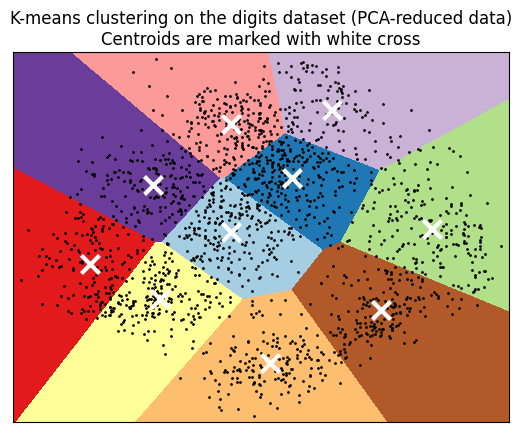

In [ ]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# A demo of structured Ward hierarchical clustering on an image of coins
Compute the segmentation of a 2D image with Ward hierarchical clustering. The clustering is spatially constrained in order for each segmented region to be in one piece.

## Generate the dataset

In [ ]:
from skimage.data import coins

In [ ]:
corig_coins = coins()

### Resize it to 20% of the original size to speed up the processing Applying a Gaussian filter for smoothing prior to down-scaling reduces aliasing artifacts.

In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale

In [ ]:
smooth_coins = gaussian_filter(corig_coins, sigma=2)
rescaled_coins = rescale(smooth_coins, 0.2, mode = "reflect", anti_aliasing=False)
X=np.reshape(rescaled_coins, (-1, 1))

In [ ]:
print(X)

[[0.50959853]
 [0.52156988]
 [0.51372549]
 ...
 [0.29816654]
 [0.2262007 ]
 [0.0351789 ]]


#Define structure of the DATA

In [ ]:
#pixels are connected to their neighbors
from sklearn.feature_extraction.image import grid_to_graph
connectivity = grid_to_graph(*rescaled_coins.shape)

### Compute Clusters

In [ ]:
import time as time
from sklearn.cluster import AgglomerativeClustering
print("Extracting features from the image...")
st = time.time()
n_clusters = 27
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage = "ward", connectivity=connectivity)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_coins.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

Extracting features from the image...
Elapsed time:  0.3166182041168213
Number of pixels:  4697
Number of clusters:  27


## Visualizing the results

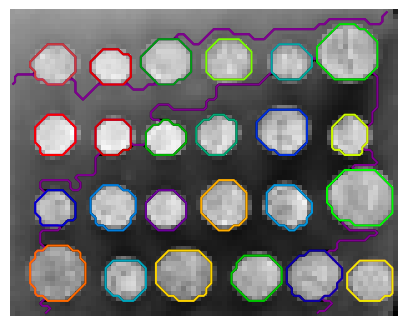

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(
        label == l,
        colors=[
            plt.cm.nipy_spectral(l / float(n_clusters)),
        ],
    )
plt.axis("off")
plt.show()

## A demo of the mean-shift clustering algorithm

In [ ]:
import numpy as np

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

#Generate Sample Data

In [ ]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

## Compute Clustering with MeanShift

In [ ]:
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 3


## Plot Result

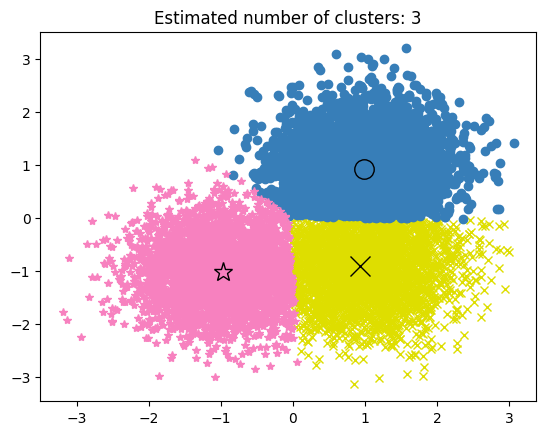

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.clf()

colors = ["#dede00", "#377eb8", "#f781bf"]
markers = ["x", "o", "*"]

for k, col in zip(range( n_clusters_), colors):
  my_members = labels ==k
  cluster_center = cluster_centers[k]
  plt.plot(X[my_members, 0], X[my_members, 1], markers[k], color = col)
  plt.plot(
      cluster_center[0],
      cluster_center[1],
      markers[k],
      markerfacecolor=col,
      markeredgecolor="k",
      markersize=14,
  )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()


Demo of DBSCAN clustering algorithm

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) finds core samples in regions of high density and expands clusters from them. This algorithm is good for data which contains clusters of similar density.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

Load the dataset

In [ ]:
#Load the data in X
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.50, random_state=0)
X, y_true

(array([[ 1.03992529,  1.92991009],
        [-1.38609104,  7.48059603],
        [ 1.12538917,  4.96698028],
        [-1.05688956,  7.81833888],
        [ 1.4020041 ,  1.726729  ],
        [ 3.20722587,  0.36765575],
        [-1.76133611,  1.81716162],
        [ 1.34081536,  4.36827878],
        [-0.37881944,  8.33265721],
        [-0.80062564,  8.52294205],
        [-1.68146124,  2.80114893],
        [-2.43304923,  8.26748617],
        [ 1.19820169,  4.47062449],
        [-2.06457304,  7.05157615],
        [ 1.55515985,  0.12527811],
        [ 0.5408715 ,  4.0143625 ],
        [ 1.05374379,  4.49286859],
        [ 2.48368283,  0.57215086],
        [-1.14357242,  3.09602867],
        [-1.15330985,  2.32340978],
        [ 2.60509732,  1.22529553],
        [ 1.82346953,  1.1384044 ],
        [ 0.77468161,  4.91500986],
        [-1.91821859,  2.86268761],
        [-1.85305081,  2.65728761],
        [-0.30022483,  4.63059663],
        [ 1.7571105 ,  0.87138001],
        [ 0.65834704,  4.642

## Modeling the Data using DBSCAN

['y', 'b', 'g', 'r']


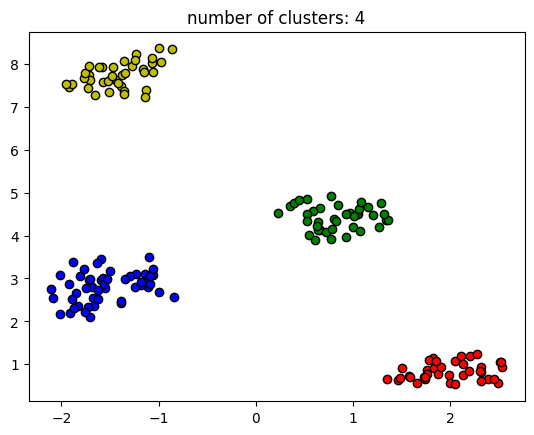

In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = ['y', 'b', 'g', 'r']
print(colors)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

plt.title('number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
# evaluation metrics
from sklearn.metrics import adjusted_rand_score
from sklearn import metrics
sc = metrics.silhouette_score(X, labels)
print("Silhouette Coefficient:%0.2f" % sc)
ari = adjusted_rand_score(y_true, labels)
print("Adjusted Rand Index: %0.2f" % ari)

Silhouette Coefficient:0.13
Adjusted Rand Index: 0.31


In [ ]:
num_dataset =